<a href="https://colab.research.google.com/github/Kunal-code-u/PneumoniaDetection/blob/main/ML_projectFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # Select your kaggle.json file

In [ ]:
!ls -l #is used to display the contents of a directory in a detailed (long) list format

total 8
-rw-r--r-- 1 root root   70 Nov 18 04:38 Kaggle.json
drwxr-xr-x 1 root root 4096 Nov 14 14:25 sample_data


In [ ]:
!mv "Kaggle.json" kaggle.json #Renames or moves the file Kaggle.json to kaggle.json.

In [ ]:
!mkdir -p ~/.kaggle #Creates the directory ~/.kaggle (in the user's home directory). If the directory already exists, no error occurs.
# It creates parent directories if needed.

!mv kaggle.json ~/.kaggle/ # Purpose: Moves the kaggle.json file into the .kaggle directory under the user's home folder (~/.kaggle).


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json #s used to set file permissions for the kaggle.json file located in the .kaggle directory under the user's home folder.

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia #Downloads the specified dataset from Kaggle.Downloads a ZIP file containing the dataset into the current working directory.


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip chest-xray-pneumonia.zip -d /content/chest_xray #Extracts the downloaded dataset into a specific directory. Extracts all files and folders from chest-xray-pneumonia.zip into /content/chest_xray.

Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  


In [ ]:
import os #Imports the os module, which provides functions for interacting with the file system.
for dirname, _, filenames in os.walk('/content/chest_xray'):
    for filename in filenames: #Loops through the list of filenames in each directory.
        print(os.path.join(dirname, filename)) #Outputs the full path of each file to the console.

Streaming output truncated to the last 5000 lines.
/content/chest_xray/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0857-0001.jpeg
/content/chest_xray/chest_xray/chest_xray/train/NORMAL/IM-0553-0001-0002.jpeg
/content/chest_xray/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1326-0001.jpeg
/content/chest_xray/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0978-0001.jpeg
/content/chest_xray/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0518-0001.jpeg
/content/chest_xray/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1148-0001.jpeg
/content/chest_xray/chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg
/content/chest_xray/chest_xray/chest_xray/train/NORMAL/IM-0331-0001.jpeg
/content/chest_xray/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0725-0001.jpeg
/content/chest_xray/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1096-0001.jpeg
/content/chest_xray/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1025-0001.jpeg
/content/chest_xray/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0449-0001.j

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Used for creating graphs and visualizations (e.g., line plots, histograms, etc.).
import seaborn as sns
import cv2 #Used to read, preprocess, and manipulate images in deep learning tasks.
import tensorflow as tf #Provides tools to build and train machine learning models.
from tensorflow.keras.models import Sequential #Sequential API allows for a linear stack of layers to define a model.
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Used for real-time data augmentation, which generates batches of image data with transformations like rotation, zoom, or flipping
from tensorflow.keras.callbacks import ReduceLROnPlateau #Callback function that reduces the learning rate when a metric (like validation loss) has stopped improving.
from sklearn.model_selection import train_test_split #Splits datasets into training and test subsets.
from sklearn.metrics import classification_report, confusion_matrix # Provides precision, recall, F1-score, and support for classification models.
#valuates the performance of classification models by showing true vs. predicted classes.

In [ ]:
#This script is designed to load and preprocess image data for a classification task (e.g., detecting pneumonia). The images are resized, reshaped, and labeled for model training, testing, and validation.
labels = ['PNEUMONIA', 'NORMAL'] #Specifies the two classes in the dataset.
img_size = 150 #The target size (height and width) for resizing images.

def get_training_data(data_dir): #processes  all images in a given directory (data_dir) and prepares them for model training or evaluation.
    data = [] #Initializes an empty list to store image data and corresponding labels.
    for label in labels:
        path = os.path.join(data_dir, label) #Constructs the directory path for the current label.
        class_num = labels.index(label) #Assigns a numeric label to the class (0 for PNEUMONIA, 1 for NORMAL).
        for img in os.listdir(path):
            try:
                # Read the image as grayscale
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) #Reads the image in grayscale using OpenCV
                # Resize the image
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                # Reshape the image array to include a channel dimension
                resized_arr = resized_arr.reshape((img_size, img_size, 1))
                # Append the resized image and class number to the data list
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    # Convert the data list to a NumPy array with a consistent dtype
    return np.array(data, dtype=object)

train = get_training_data('/content/chest_xray/chest_xray/chest_xray/train')
test = get_training_data('/content/chest_xray/chest_xray/chest_xray/test')
val = get_training_data('/content/chest_xray/chest_xray/chest_xray/val')

OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [ ]:
!ls /content

chest_xray  chest-xray-pneumonia.zip  sample_data


In [ ]:
!ls /content/chest_xray
!ls /content/chest_xray/train
!ls /content/chest_xray/train/PNEUMONIA


chest_xray
ls: cannot access '/content/chest_xray/train': No such file or directory
ls: cannot access '/content/chest_xray/train/PNEUMONIA': No such file or directory


In [ ]:
!ls -R /content/chest_xray


/content/chest_xray:
chest_xray

/content/chest_xray/chest_xray:
chest_xray  __MACOSX  test  train  val

/content/chest_xray/chest_xray/chest_xray:
test  train  val

/content/chest_xray/chest_xray/chest_xray/test:
NORMAL	PNEUMONIA

/content/chest_xray/chest_xray/chest_xray/test/NORMAL:
IM-0001-0001.jpeg	   NORMAL2-IM-0033-0001.jpeg	   NORMAL2-IM-0280-0001.jpeg
IM-0003-0001.jpeg	   NORMAL2-IM-0035-0001.jpeg	   NORMAL2-IM-0281-0001.jpeg
IM-0005-0001.jpeg	   NORMAL2-IM-0041-0001.jpeg	   NORMAL2-IM-0282-0001.jpeg
IM-0006-0001.jpeg	   NORMAL2-IM-0045-0001.jpeg	   NORMAL2-IM-0283-0001.jpeg
IM-0007-0001.jpeg	   NORMAL2-IM-0051-0001.jpeg	   NORMAL2-IM-0285-0001.jpeg
IM-0009-0001.jpeg	   NORMAL2-IM-0052-0001.jpeg	   NORMAL2-IM-0286-0001.jpeg
IM-0010-0001.jpeg	   NORMAL2-IM-0058-0001.jpeg	   NORMAL2-IM-0287-0001.jpeg
IM-0011-0001-0001.jpeg	   NORMAL2-IM-0059-0001.jpeg	   NORMAL2-IM-0288-0001.jpeg
IM-0011-0001-0002.jpeg	   NORMAL2-IM-0060-0001.jpeg	   NORMAL2-IM-0289-0001.jpeg
IM-0011-0001.jpeg	 

In [ ]:
# This block processes the data prepared earlier (train, test, and val) into separate
# feature and label arrays, normalizes the images, and reshapes them for input into a machine learning or deep learning model
x_train, y_train = [], [] #Initializes empty lists for features (x_*) and labels (y_*) for the training, testing, and validation sets.
x_test, y_test = [], []
x_val, y_val = [], []

for feature, label in train: #For each tuple (feature, label) in the dataset:
# x_*: Appends the image array (features).
# y_*: Appends the corresponding label.
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

# Normalize data
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0
x_val = np.array(x_val) / 255.0

# Reshape data for the model
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)


In [ ]:
# This snippet uses the ImageDataGenerator class from Keras to perform real-time data augmentation on the training data.
# Data augmentation generates transformed versions of the existing images, which helps improve the model's ability to generalize.

datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)


In [ ]:
# This script defines and compiles a Convolutional Neural Network (CNN) for binary classification, suitable for detecting conditions like pneumonia in grayscale chest X-ray images.
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 1)), #Extract spatial features from images using filters.
    BatchNormalization(), #Normalizes the output of a layer to stabilize and accelerate training.
    MaxPool2D(2,2), #Purpose: Reduces the spatial dimensions of feature maps, retaining only the most important features.
    Conv2D(64, (3,3), activation='relu'),
    Dropout(0.1), # Randomly "drops" a fraction of neurons during training to prevent overfitting.
    BatchNormalization(),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D(2,2),
    Flatten(), #Flattens the 2D feature maps into a 1D vector to connect to fully connected layers.
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 72, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │              

 Total params: 558,273 (2.13 MB)

 Trainable params: 557,185 (2.13 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [ ]:
#This callback adjusts the learning rate during training when the model's performance plateaus, specifically when the validation accuracy doesn't improve for a set number of epochs.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.3, min_lr=0.000001)


In [ ]:
# This line starts the training process of the model using the augmented data from the ImageDataGenerator and applies the learning rate reduction callback to adjust the learning rate during training based on the validation accuracy.
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=12,
    validation_data=(x_val, y_val),
    callbacks=[learning_rate_reduction]
)


Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - accuracy: 0.8191 - loss: 0.5415 - val_accuracy: 0.5000 - val_loss: 20.4213 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.8992 - loss: 0.2431 - val_accuracy: 0.5000 - val_loss: 25.7796 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9072 - loss: 0.2231 - val_accuracy: 0.5000 - val_loss: 15.0697 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9358 - loss: 0.1612 - val_accuracy: 0.6875 - val_loss: 1.6651 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9403 - loss: 0.1525 - val_accuracy: 0.8750 - val_loss: 0.4249 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9509 - loss: 0.1346 - val_accuracy: 0.5000 - val_loss: 9.0516 - learning_rate: 3.0000e-04
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - accuracy: 0.9522

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Model Test Loss: {loss}")
print(f"Model Test Accuracy: {accuracy * 100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9607 - loss: 0.1244
Model Test Loss: 0.22611580789089203
Model Test Accuracy: 91.67%


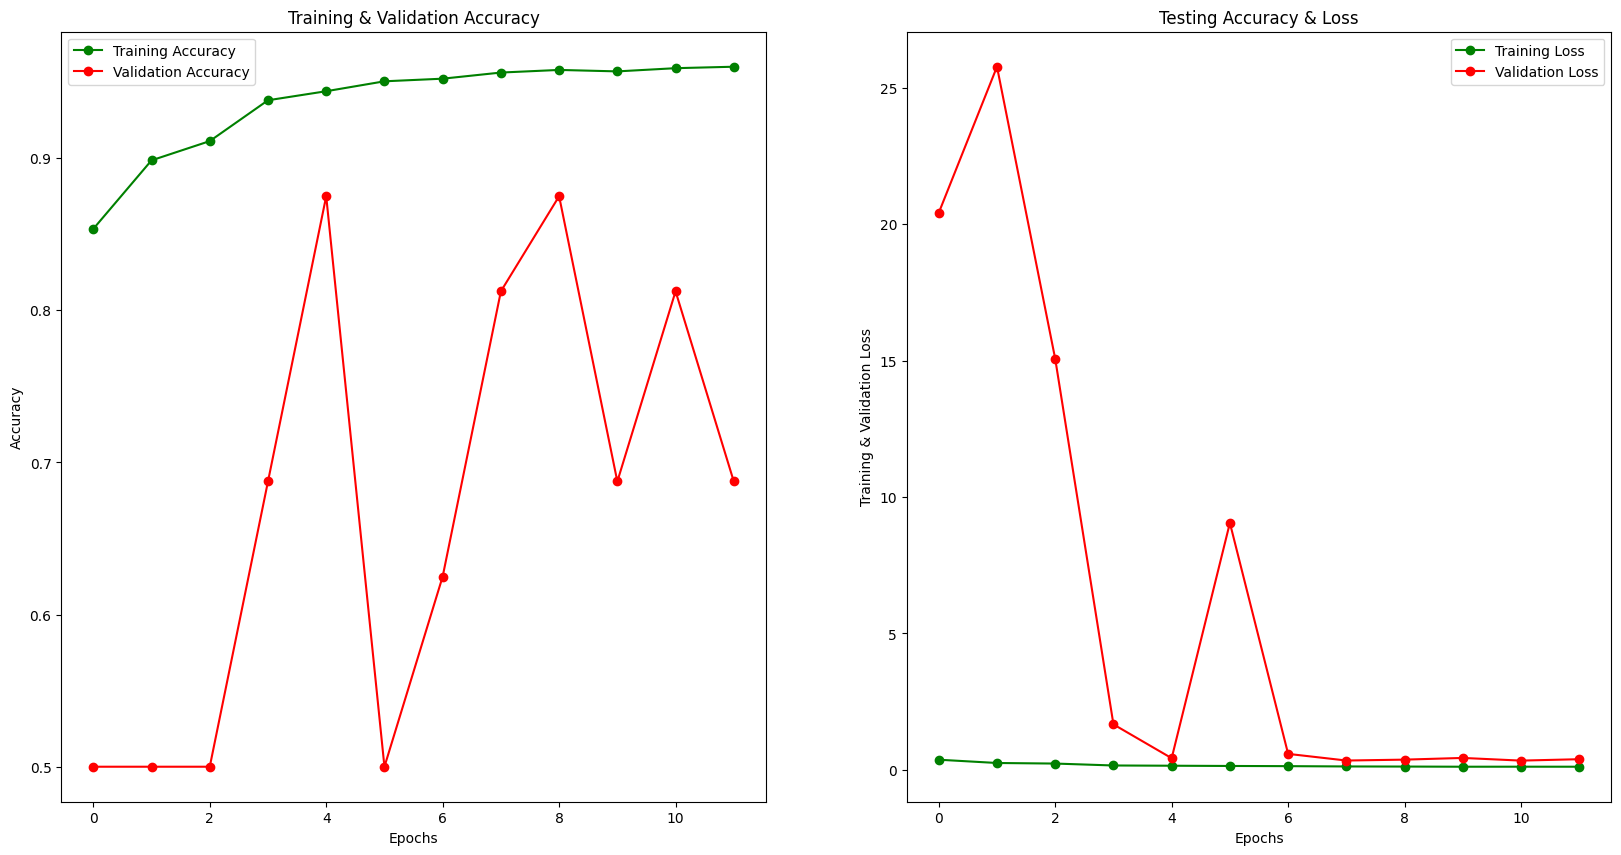

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2) #Creates a 1x2 grid of subplots, meaning two plots side by side in the same figure.
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

# First Plot: Training & Validation Accuracy

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Second Plot: Training & Validation Loss

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
# This code is used to obtain predictions from the trained model, convert those predictions into class labels (0 or 1), and display the first 15 predictions. Here's a step-by-step breakdown
# Get predictions as probabilities
predictions = model.predict(x_test)

# Convert probabilities to class labels (0 or 1) by applying a threshold
predictions = (predictions > 0.5).astype("int32")

# Flatten the array for easier readability
predictions = predictions.reshape(1, -1)[0]

# Display the first 15 predictions
predictions[:15]


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.98      0.94       390
   Normal (Class 1)       0.96      0.81      0.88       234

           accuracy                           0.92       624
          macro avg       0.93      0.90      0.91       624
       weighted avg       0.92      0.92      0.92       624



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[382,   8],
       [ 44, 190]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

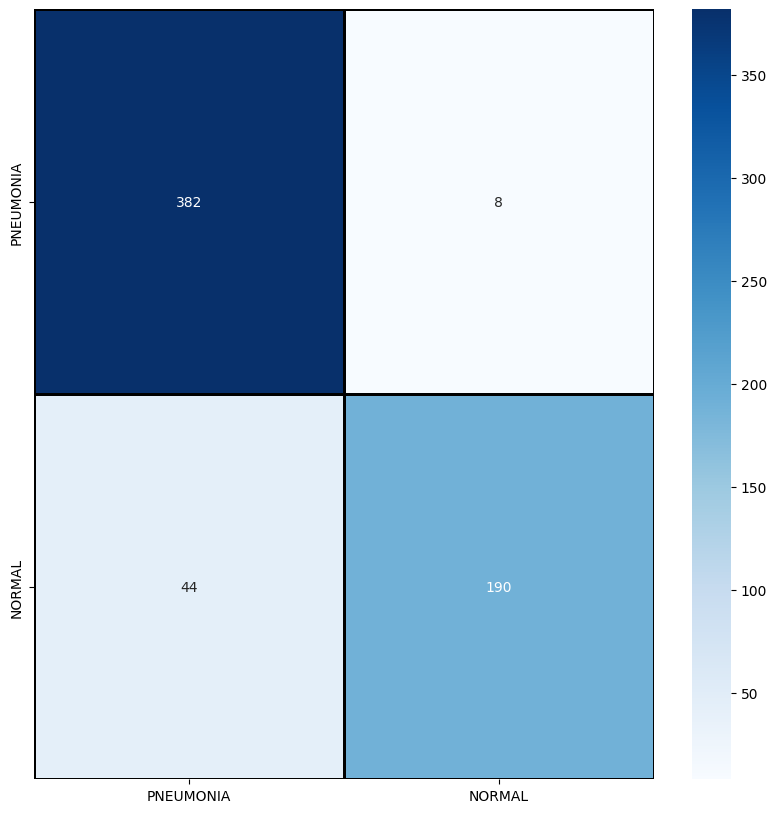

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

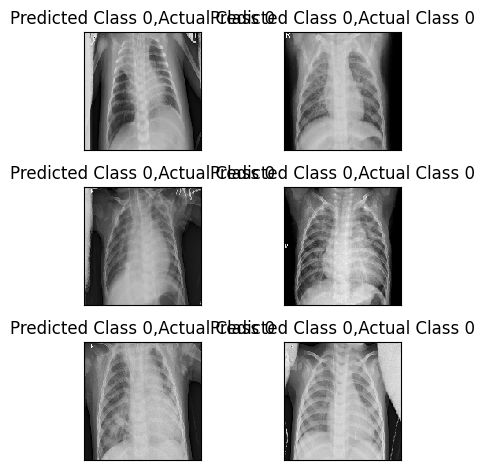

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1